# ProbCox
Example script accompyining "Probabilistic Cox regression via stochastic variational inference" to showcase a simple simulation for the standard case setting. 

First download and install the package probcox from pip:

In [1]:
!pip3 install probcox

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 614kB 5.3MB/s 
  Created wheel for probcox: filename=probcox-0.0.3-cp37-none-any.whl size=5293 sha256=40ef6a11b4078ee79d2c12faa8f315111ad37fe92ae2a63083e28226244c4f83
  Stored in directory: /root/.cache/pip/wheels/ac/31/f1/c1d74c273172b3c28f49c17c66700ef14ad55eb418ec867bdc
Successfully built probcox


Then we load some other python packages that we will be using along the way:

In [2]:
import tqdm
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import probcox as pcox

import warnings
warnings.filterwarnings("ignore") # stopping some warning messages - that clutter some of the output.

dtype = torch.FloatTensor # standard array type

# set seeds for replication
np.random.seed(9834)
torch.manual_seed(875)

Now we simulate some example data that we use for inference later:


In [3]:
# define true parameter values
theta = np.random.uniform(-2, 2, (10, 1))

# number and type of covariates
P_binary = 5
P_continuous = 5

(array([  9.,  21.,  73., 149., 230., 252., 153.,  82.,  23.,   8.]),
 array([-6.83401881, -5.4176666 , -4.0013144 , -2.5849622 , -1.16860999,
         0.24774221,  1.66409441,  3.08044662,  4.49679882,  5.91315103,
         7.32950323]),
 <a list of 10 Patch objects>)

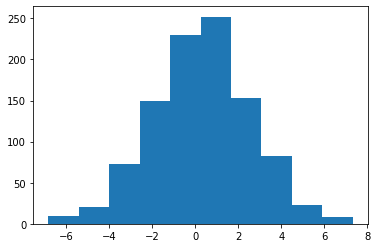

In [4]:
# rough distribution for the corresponding linear effect size
X = np.concatenate((np.random.binomial(1, 0.2, (1000, P_binary)), np.random.normal(0, 1, (1000, P_continuous))), axis=1)
plt.hist(np.matmul(X, theta))

In [5]:
# setup the class for simulkation 
TVC = pcox.TVC(theta=theta, P_binary=P_binary, P_continuous=P_continuous, dtype=dtype)

# define the baseline hazard - scale is set to achieve a rough level of censorship (increase for higher censorship)
TVC.make_lambda0(scale=1.5)
# gauge the number to desired level of censorship
print('\n Censorship: ', str(1 - (np.sum([torch.sum(TVC.sample()[0][:, -1]).numpy() for ii in tqdm.tqdm(range(1000))])/1000)))

100%|██████████| 1000/1000 [00:02<00:00, 358.20it/s]


 Censorship:  0.5349999999999999


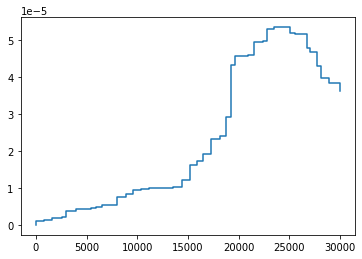

In [6]:
# Return the underlying shape of the baseline hazard and plot
t_l, ll = TVC.return_lambda0()
plt.step(t_l, ll)

In [7]:
# simulate data set
surv = torch.zeros((0, 3))
X = torch.zeros((0, theta.shape[0]))
for __ in tqdm.tqdm(range(10000)):
    a, b = TVC.sample()
    surv = torch.cat((surv, a))
    X = torch.cat((X, b))

100%|██████████| 10000/10000 [00:32<00:00, 307.64it/s]


In [8]:
print('Interval observation: ', str(surv.shape[0]))
print('Number of events: ', str(torch.sum(surv[:, -1] == 1).numpy().tolist()))

Interval observation:  61328
Number of events:  4889


In [9]:
# Collect sample information for re-weigthing of likelihood
total_obs = surv.shape[0]
total_events = torch.sum(surv[:, -1] == 1).numpy().tolist()
sampling_proportion=[total_obs, None, total_events, None]

After simulating the data we can run the probcox on the generated data:

In [10]:
# set desired level of batchsize
batchsize = 256

In [11]:
# run inference
sampling_proportion[1] = batchsize
eta=10
run = True
while run:
    run = False
    pyro.clear_param_store()
    m = pcox.PCox(sampling_proportion=sampling_proportion)
    m.initialize(eta=eta, num_particles=5)
    loss=[0]
    for ii in tqdm.tqdm(range((10000))):
        # random sub-sampling - define at least 2 events - otherwise thre is no effect on the loglikelihood.
        idx = np.concatenate((np.random.choice(np.where(surv[:, -1]==1)[0], 2, replace=False), np.random.choice(range(surv.shape[0]), batchsize-2, replace=False)))
        data=[surv[idx], X[idx]]
        loss.append(m.infer(data=data))
        # divergence check
        if loss[-1] != loss[-1]:
            eta = eta * 0.1
            run=True
            break   

100%|██████████| 10000/10000 [03:28<00:00, 47.85it/s]


In [12]:
# extract the parameter values and lower/upper bounds
g = m.return_guide()
out = g.quantiles([0.025, 0.5, 0.975])
print(out)

{'theta': [tensor([[-1.9204],
        [-0.6400],
        [ 1.3893],
        [ 1.0328],
        [ 1.6131],
        [ 0.6254],
        [ 0.4578],
        [ 1.3850],
        [-0.0510],
        [ 0.8929]], grad_fn=<ViewBackward>), tensor([[-1.7742],
        [-0.5333],
        [ 1.4712],
        [ 1.1126],
        [ 1.6929],
        [ 0.6670],
        [ 0.4956],
        [ 1.4263],
        [-0.0133],
        [ 0.9308]], grad_fn=<ViewBackward>), tensor([[-1.6279],
        [-0.4267],
        [ 1.5531],
        [ 1.1924],
        [ 1.7726],
        [ 0.7087],
        [ 0.5334],
        [ 1.4677],
        [ 0.0243],
        [ 0.9687]], grad_fn=<ViewBackward>)]}


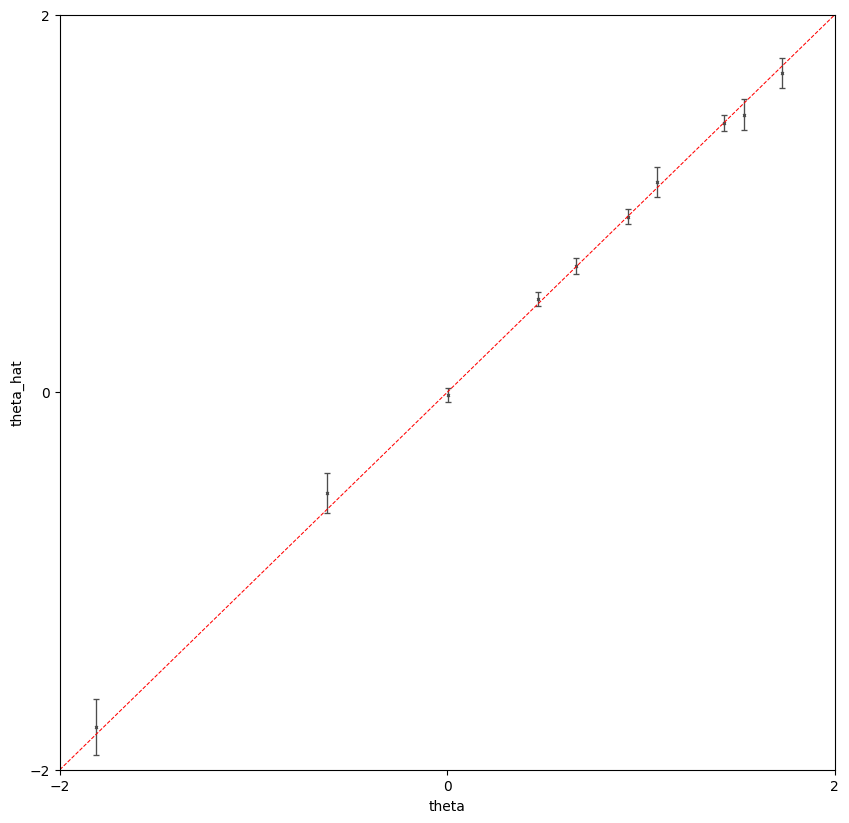

In [13]:
# plot the results
theta_est = out['theta'][1].detach().numpy()
theta_est_lower = out['theta'][0].detach().numpy()
theta_est_upper = out['theta'][2].detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)  
ax.errorbar(theta[:, 0], theta_est[:, 0], yerr=(theta_est[:, 0] - theta_est_lower[:, 0], theta_est_upper[:, 0]- theta_est[:, 0]),  ls='', c=".3", capsize=2, capthick=0.95, elinewidth=0.95)
ax.plot(theta[:, 0], theta_est[:, 0], ls='', c=".3", marker='x', ms=2)
ax.set(xlim=(-2, 2), ylim=(-2, 2))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="red", linewidth=0.75)
ax.set_yticks([-2, 0, 2])
ax.set_ylim([-2, 2])
ax.set_xticks([-2, 0, 2])
ax.set_xlim([-2, 2])
ax.set_xlabel('theta')
ax.set_ylabel('theta_hat')
plt.show()
plt.close()


Run the same analysis but change the prior distribution now:


In [14]:
# Here we can define a custom linear predictor which is then evalauted corresponding to the Cox Partial Likelihood
def predictor(data):
    theta =  pyro.sample("theta", dist.StudentT(1, loc=0, scale=0.001).expand([data[1].shape[1], 1])).type(dtype)
    pred = torch.mm(data[1], theta)
    return(pred)

In [15]:
# run inference
sampling_proportion[1] = batchsize
eta=10
run = True
while run:
    run = False
    pyro.clear_param_store()
    m = pcox.PCox(sampling_proportion=sampling_proportion, predictor=predictor) # !!!!!!!!!! change predictor from default normal(0,1)
    m.initialize(eta=eta, num_particles=5)
    loss=[0]
    for ii in tqdm.tqdm(range((10000))):
        # random sub-sampling - define at least 2 events - otherwise thre is no effect on the loglikelihood.
        idx = np.concatenate((np.random.choice(np.where(surv[:, -1]==1)[0], 2, replace=False), np.random.choice(range(surv.shape[0]), batchsize-2, replace=False)))
        data=[surv[idx], X[idx]]
        loss.append(m.infer(data=data))
        # divergence check
        if loss[-1] != loss[-1]:
            eta = eta * 0.1
            run=True
            break   

100%|██████████| 10000/10000 [03:34<00:00, 46.53it/s]


In [16]:
# extract the parameter values and lower/upper bounds
g = m.return_guide()
out = g.quantiles([0.025, 0.5, 0.975])
print(out)

{'theta': [tensor([[-1.9197],
        [-0.6236],
        [ 1.3891],
        [ 1.0261],
        [ 1.6118],
        [ 0.6256],
        [ 0.4574],
        [ 1.3840],
        [-0.0254],
        [ 0.8908]], grad_fn=<ViewBackward>), tensor([[-1.7759],
        [-0.5225],
        [ 1.4698],
        [ 1.1104],
        [ 1.6921],
        [ 0.6658],
        [ 0.4939],
        [ 1.4241],
        [ 0.0029],
        [ 0.9305]], grad_fn=<ViewBackward>), tensor([[-1.6321],
        [-0.4214],
        [ 1.5505],
        [ 1.1947],
        [ 1.7725],
        [ 0.7060],
        [ 0.5304],
        [ 1.4642],
        [ 0.0312],
        [ 0.9702]], grad_fn=<ViewBackward>)]}


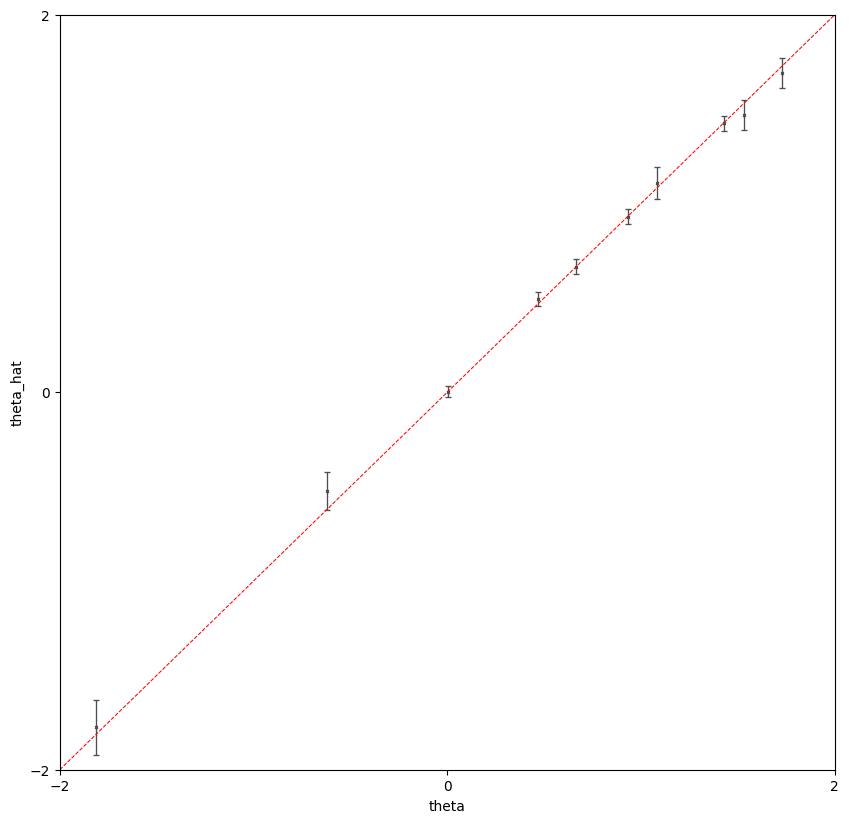

In [17]:
# plot the results
theta_est = out['theta'][1].detach().numpy()
theta_est_lower = out['theta'][0].detach().numpy()
theta_est_upper = out['theta'][2].detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)  
ax.errorbar(theta[:, 0], theta_est[:, 0], yerr=(theta_est[:, 0] - theta_est_lower[:, 0], theta_est_upper[:, 0]- theta_est[:, 0]),  ls='', c=".3", capsize=2, capthick=0.95, elinewidth=0.95)
ax.plot(theta[:, 0], theta_est[:, 0], ls='', c=".3", marker='x', ms=2)
ax.set(xlim=(-2, 2), ylim=(-2, 2))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="red", linewidth=0.75)
ax.set_yticks([-2, 0, 2])
ax.set_ylim([-2, 2])
ax.set_xticks([-2, 0, 2])
ax.set_xlim([-2, 2])
ax.set_xlabel('theta')
ax.set_ylabel('theta_hat')
plt.show()
plt.close()
